In [1]:
%matplotlib widget
import os
import io
import pickle
import contextlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from omars_little_helpers import *
from ode_system import *
import pandas as pd
import seaborn as sns

## 1) Import GR Solutions

In [19]:
GR_file_path = './output/GR/GR_full_star_solution.pkl'

with open(GR_file_path, 'rb') as file:
    GR_results = pickle.load(file)

data = []
# Loop through each result in GR_results
for star in GR_results:
    # Extract needed values
    rho_c = star['rho_c'] 
    radius = star['radius']
    mass = star['mass']
    
    # Append the data to the list
    data.append({
        'rho_c': rho_c,
        'radius': radius,
        'mass': mass
    })

# Creating identifiers for GR data
GR_identifier = [('GR', i) for i in range(len(GR_results))]  

# Modify GR struct to fit the pre-existing output
GR_modified_data = [{
    'identifier': identifier,
    'rho_c': star['rho_c'],
    'a_c': None, 
    'mass': star['mass'],
    'radius': star['radius']
} for identifier, star in zip(GR_identifier, GR_results)]


## 2) Import Salar-Tensor Solutions

In [20]:
# import star data
run_name = []
dir_to_sol = []
results = []

for dirname,_,filenames in os.walk('./output'):
    for filename in filenames:
        if filename.endswith('full_star_solutions.pkl'):
            print(os.path.join(dirname,filename))
            dir_to_sol.append(os.path.join(dirname,filename))
            run_name.append(dirname.split('/')[-1])

for dir in dir_to_sol:
    with open(dir, 'rb') as file:
        result = pickle.load(file)
        results.append(result)
    

./output/fa6e19_ma-15_gs63e-22/fa6e19_ma-15_gs63e-22_full_star_solutions.pkl
./output/ma15_gsN9e-25/ma15_gsN9e-25_full_star_solutions.pkl
./output/fa15e15_ma12_gsN2e-25/fa15e15_ma12_gsN2e-25_full_star_solutions.pkl
./output/fa2e18_ma13_gsN3e-22/fa2e18_ma13_gsN3e-22_full_star_solutions.pkl
./output/fa2e18_ma12_gsN3e-23/fa2e18_ma12_gsN3e-23_full_star_solutions.pkl


In [23]:
# initialize a list to store combined data
axion_data = []

# continue using the array_solutions dictionary for array data
array_solutions = {key: {} for key in ['rho', 'a_in', 'a_out', 'a_prime_in', 'a_prime_out', 'nu_in', 
                                       'nu_out', 'llambda_in', 'llambda_out', 'r_inside', 'r_outside']}

# process data
for run_idx, (run, result) in enumerate(zip(run_name, results)):
    for star_idx, star_data in enumerate(result):
        # Create a unique identifier for each star in each run
        identifier = (run, star_idx)
        
        # combine scalar data for DataFrame
        axion_data.append({
            'identifier': identifier,
            'rho_c': star_data['rho'][0],  # first entry of rho
            'a_c': star_data['a_c'],
            'mass': star_data['mass'],
            'radius': star_data['radius']
        })
        
        # store array solutions
        for key in array_solutions.keys():
            array_solutions[key][identifier] = star_data[key]
axion_data.extend(GR_modified_data)

# Create a single DataFrame
combined_df = pd.DataFrame(axion_data).set_index('identifier')
combined_df.index = pd.MultiIndex.from_tuples(combined_df.index, names=['run_name', 'star_id'])

# Reorder DataFrame columns
combined_df = combined_df[['rho_c', 'a_c', 'mass', 'radius']]


# Now, we have:
# - combined_df: A DataFrame with scalar values and rho_c[0] for all runs and stars
# - array_solutions: A dictionary with nested dictionaries for array solutions

# Example of accessing scalar data:
# To get the mass and radius of the first star in the first run:
# first_run_star_info = combined_df.loc[(run_name[0], 0), ['mass', 'radius']]

# To get the 'rho' array of the first star in the first run:
# first_run_star_rho = array_solutions['rho'][(run_name[0], 0)]

run_name += ['GR']

In [25]:
combined_df.index.get_level_values('run_name').unique()

Index(['fa6e19_ma-15_gs63e-22', 'ma15_gsN9e-25', 'fa15e15_ma12_gsN2e-25',
       'fa2e18_ma13_gsN3e-22', 'fa2e18_ma12_gsN3e-23', 'GR'],
      dtype='object', name='run_name')

In [26]:
combined_df.loc[run_name[1]].head(10)

,rho_c,a_c,mass,radius
star_id,,,,
0,4.000000e+14,-0.000969,0.279968,1.315950e+06
1,4.196808e+14,-0.001053,0.307616,1.278725e+06
2,4.403300e+14,-0.001146,0.338786,1.249336e+06
3,4.619951e+14,-0.001247,0.373367,1.224862e+06
4,4.847262e+14,-0.001357,0.411058,1.204590e+06
5,5.085758e+14,-0.001477,0.452743,1.188468e+06
6,5.335988e+14,-0.001608,0.498607,1.175803e+06
7,5.598529e+14,-0.001750,0.548844,1.166644e+06
8,5.873988e+14,-0.001903,0.603435,1.159610e+06


## 3) Confirm solutions are correct

In [27]:
# Check whether all the solutions obey the boundary condition a(r->infty) = 0 
for run in run_name:
    if run != 'GR':
        print(f"For run {run}: checking the condition a(r->infty) = 0")
        for idx in range(len(combined_df.loc[run])):
            a_out_i = array_solutions['a_out'][(run,idx)]
            if abs(a_out_i[-1])>1e-10:
                print(f"For star {idx}, a'(r_far) = {a_out_i[-1]}")


For run fa6e19_ma-15_gs63e-22: checking the condition a(r->infty) = 0
For run ma15_gsN9e-25: checking the condition a(r->infty) = 0
For run fa15e15_ma12_gsN2e-25: checking the condition a(r->infty) = 0
For run fa2e18_ma13_gsN3e-22: checking the condition a(r->infty) = 0
For run fa2e18_ma12_gsN3e-23: checking the condition a(r->infty) = 0


- Let's diagnose a run

Star of rho_c = 6.466e+14 g/cm^3 ---> M,R = (0.726 Solar Masses, 11.519 km) 


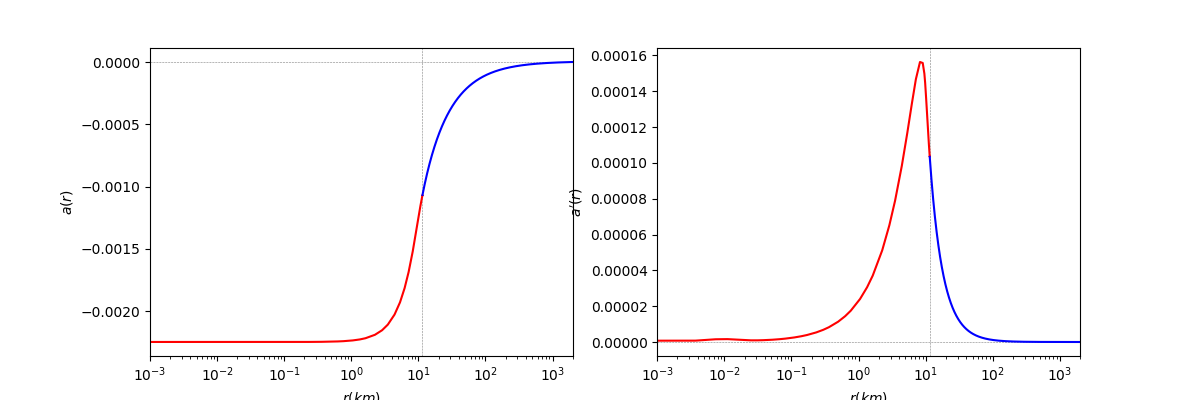

In [28]:
run_to_plot = run_name[1]
# star number
idx = 10
r_in = array_solutions['r_inside'][(run_to_plot,idx)]
r_out = array_solutions['r_outside'][(run_to_plot,idx)]
nu_out = array_solutions['nu_out'][(run_to_plot,idx)]


radius = combined_df.loc[(run_to_plot, idx), 'radius']
mass = combined_df.loc[(run_to_plot, idx), 'mass']
rho_c = combined_df.loc[(run_to_plot, idx), 'rho_c']


print(f"Star of rho_c = {rho_c:0.3e} g/cm^3 ---> M,R = ({mass:0.3f} Solar Masses, {radius/1e5:0.3f} km) ")
plt.close('all')

# set the figure size large enough to accommodate two side-by-side plots
plt.figure(figsize=(12, 4))  

plot_full_side_by_side(r_in, r_out, radius, array_solutions['a_in'][(run_to_plot,idx)], array_solutions['a_out'][(run_to_plot,idx)], 'a(r)', subplot_index=1)
plot_full_side_by_side(r_in, r_out, radius, array_solutions['a_prime_in'][(run_to_plot,idx)], array_solutions['a_prime_out'][(run_to_plot,idx)], 'a\'(r)', subplot_index=2)

#plt.savefig("optimized_ac.pdf")
plt.show()

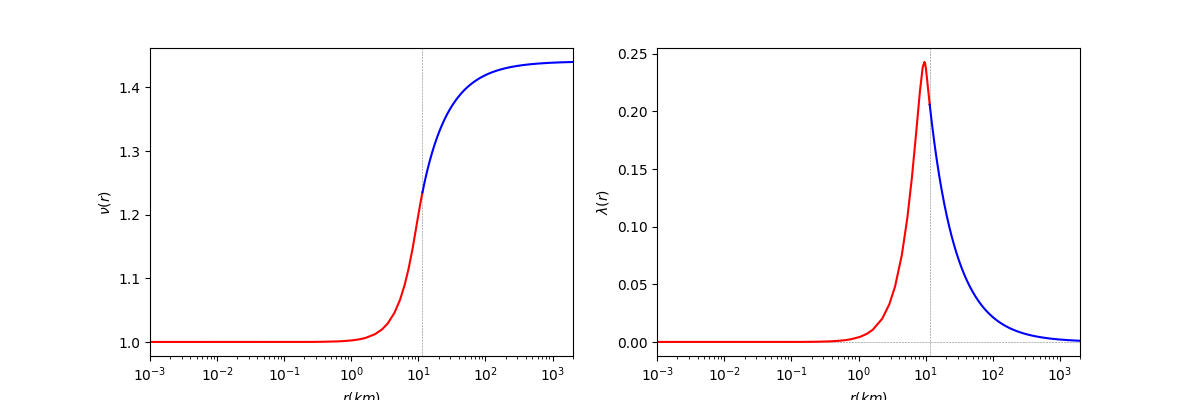

In [29]:
plt.close('all')

# set the figure size large enough to accommodate two side-by-side plots
plt.figure(figsize=(12, 4))  

plot_full_side_by_side(r_in, r_out, radius, array_solutions['nu_in'][(run_to_plot,idx)], array_solutions['nu_out'][(run_to_plot,idx)], r"\nu(r)", subplot_index=1)
plot_full_side_by_side(r_in, r_out, radius, array_solutions['llambda_in'][(run_to_plot,idx)], array_solutions['llambda_out'][(run_to_plot,idx)], "\lambda(r)", subplot_index=2)

plt.show()

In [30]:
# Mass from matching the metric potetial
# Interpolate nu_out over a finer grid
r_fine = np.linspace(r_out[0], r_out[-1], 100000)  # Define a finer grid
nu_interp = interp1d(r_out, nu_out, kind='cubic')  # Cubic interpolation

# Estimate the derivative using finite differences
nu_prime_out = np.gradient(nu_interp(r_fine), r_fine)[-1]  # Estimate derivative at the boundary

# Calculate the mass
mass = (c**2 * r_out[-1]**2 * nu_prime_out) / (2 * G * (1 + nu_prime_out * r_out[-1])) / Msun
print(f"Estimated Mass: {mass:0.3f} Solar Masses")

Estimated Mass: 0.726 Solar Masses


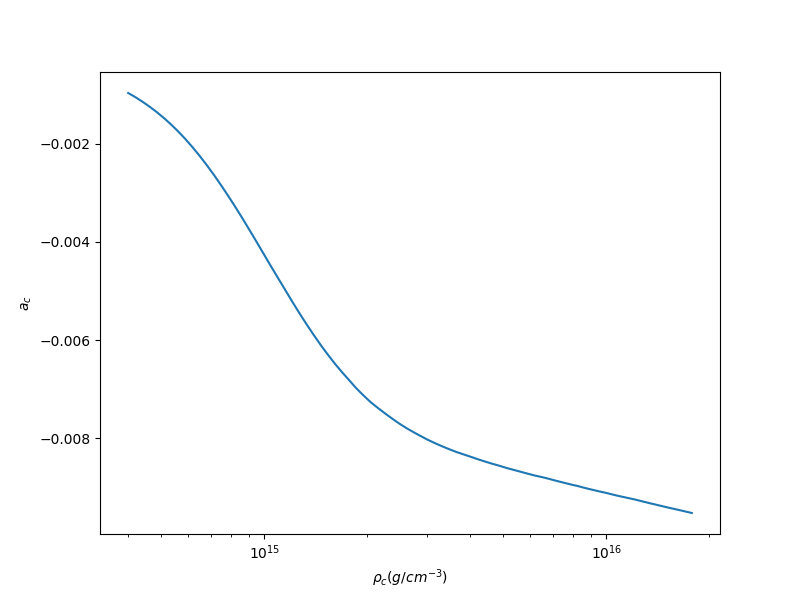

In [31]:
plt.close('all')

ax_rho_c = combined_df.loc[run_to_plot].rho_c
ax_a_c = combined_df.loc[run_to_plot].a_c
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(ax_rho_c, ax_a_c, label=r"$Solutions$")
ax.set_xlabel(r"$\rho_c (g/cm^{-3})$")
ax.set_ylabel(r"$a_c$");
ax.set_xscale("log")

## 4) Plot Mass-Radius Relationship

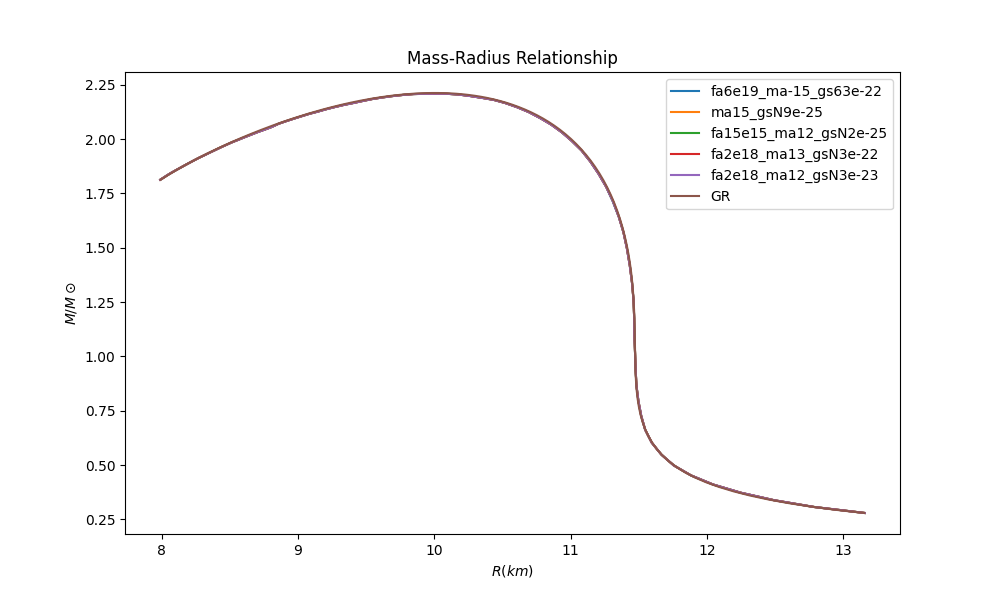

In [32]:
# Add or remove run names as needed
selected_runs = ['GR','ma15_gsN9e-25','fa6e19_ma-15_gs63e-22','fa2e18_ma13_gsN3e-22']  

# Set the figure size for better readability
plt.figure(figsize=(10, 6))

# Iterate over each selected run_name to plot its mass vs. radius curve
for name in run_name:
    # Filter the DataFrame for the current name
    subset_df = combined_df.loc[name]
    # Plot mass vs. radius for the current name
    sns.lineplot(x=subset_df['radius']/1e5, y=subset_df['mass'], label=name)
# Set the plot labels and title
plt.xlabel(r'$R (km)$')
plt.ylabel(r'$M/M\odot$')
plt.title('Mass-Radius Relationship')
#plt.xlim(8,13)
#plt.ylim(0.25,2.25)

plt.show()